<a href="https://colab.research.google.com/github/yezzzzin/object-detectinon/blob/main/data_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


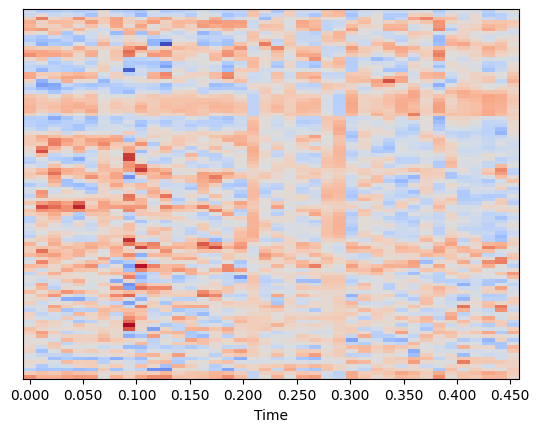

In [1]:
import librosa
import librosa.display
import numpy as np
import sklearn.preprocessing

# 목표로 하는 샘플링 레이트
target_sr = 44100

# 오디오 파일 경로 지정
audio_file = '/content/drive/MyDrive/보이스피싱 데이터(앞뒤 자르기만 하고 다 합친 것)/보이스피싱 데이터 머지 파일.wav'

# 오디오 데이터 로드
audio, sr = librosa.load(audio_file, sr=target_sr)

#디노이즈 과정이 사전에 필요
#wav파일이면 librosa쓸 수 있으나 csv파일은 librosa 못 씀

# MFCC 추출
mfcc = librosa.feature.mfcc(y=audio, sr=target_sr, n_mfcc=100, n_fft=400, hop_length=4410)

# MFCC 스케일링
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)

# 2D 패딩 함수 정의
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

# MFCC를 40개의 열로 패딩
padded_mfcc = pad2d(mfcc, 40)

# 패딩된 MFCC 시각화
librosa.display.specshow(padded_mfcc, sr=target_sr, x_axis='time')

#다 되면 csv파일로 MFCC저장하기

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import scipy
import os


# Load audio data
sr, x = scipy.io.wavfile.read('/content/drive/MyDrive/보이스피싱 데이터(앞뒤 자르기만 하고 다 합친 것)/보이스피싱 데이터 머지 파일.wav')

# Separate stereo channels
x_left = x[:, 0]
x_right = x[:, 1]

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## Process the left channel
nn = range(nwin, len(x_left), nstep)
X_left = np.zeros((len(nn), nfft//2))

for i, n in enumerate(nn):
    xseg = x_left[n-nwin:n]
    if len(xseg) < nfft:  # Zero-pad if necessary
        xseg = np.pad(xseg, (0, nfft - len(xseg)), 'constant')
    z = np.fft.fft(window * xseg, nfft)
    X_left[i, :] = np.log(np.abs(z[:nfft//2]))

## Process the right channel
nn = range(nwin, len(x_right), nstep)
X_right = np.zeros((len(nn), nfft//2))

for i, n in enumerate(nn):
    xseg = x_right[n-nwin:n]
    if len(xseg) < nfft:  # Zero-pad if necessary
        xseg = np.pad(xseg, (0, nfft - len(xseg)), 'constant')
    z = np.fft.fft(window * xseg, nfft)
    X_right[i, :] = np.log(np.abs(z[:nfft//2]))

plt.figure(figsize=(12, 4))
plt.imshow(X_left.T, interpolation='nearest',
           origin='lower',
           aspect='auto')
plt.show()

plt.figure(figsize=(12, 4))
plt.imshow(X_right.T, interpolation='nearest',
           origin='lower',
           aspect='auto')
plt.show()

import time

path = '/content/drive/MyDrive/보이스피싱 데이터(앞뒤 자르기만 하고 다 합친 것)/보이스피싱 데이터 머지 파일.wav'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
    for file in files:
        try:
            # Load librosa array, obtain mfcss, store the file and the mcss information in a new array
            X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
            file = int(file[7:8]) - 1
            arr = mfccs, file
            lst.append(arr)
        except Exception as e:
            print(f"Error encountered while processing {file}: {e}")
            continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

<ipython-input-3-ace5063a5c1e>:34: RuntimeWarning: divide by zero encountered in log
  X_left[i, :] = np.log(np.abs(z[:nfft//2]))
<ipython-input-3-ace5063a5c1e>:45: RuntimeWarning: divide by zero encountered in log
  X_right[i, :] = np.log(np.abs(z[:nfft//2]))


<ipython-input-10-b8900a5db540>:53: RuntimeWarning: divide by zero encountered in log
  X_left[j, :] = np.log(np.abs(z[:nfft//2]))


--- Data loaded. Loading time: 10.61420202255249 seconds ---


<ipython-input-10-b8900a5db540>:77: RuntimeWarning: divide by zero encountered in log
  X_left[i, :] = np.log(np.abs(z[:nfft//2]))
<ipython-input-10-b8900a5db540>:88: RuntimeWarning: divide by zero encountered in log
  X_right[i, :] = np.log(np.abs(z[:nfft//2]))


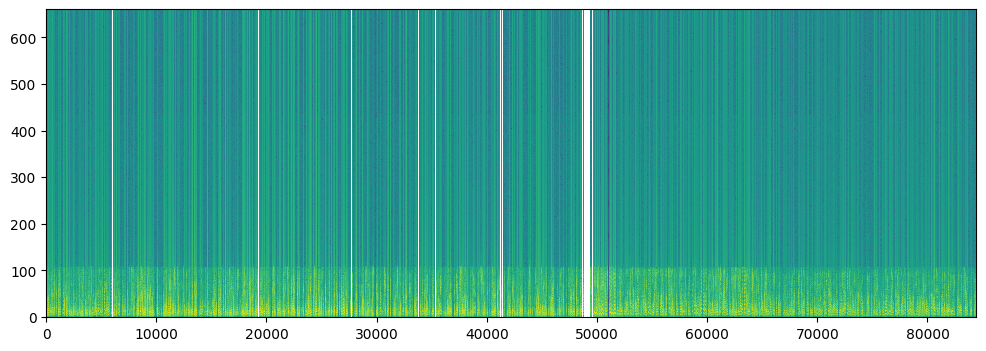

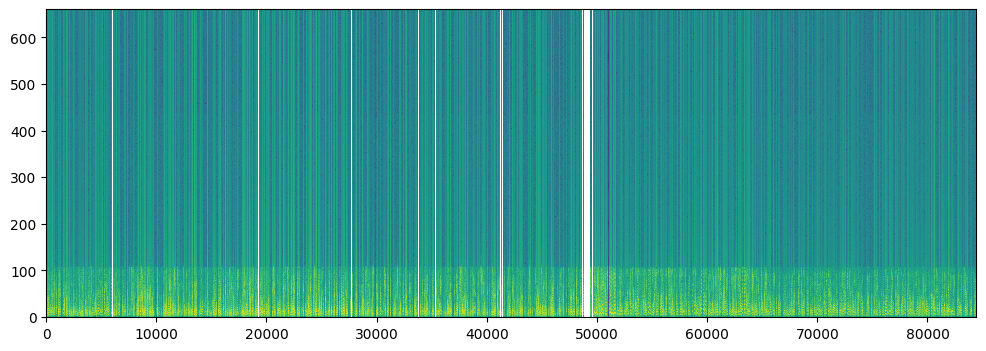

--- Data loaded. Loading time: 0.000904083251953125 seconds ---


In [10]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import scipy
import os
import wave
import time

# Load audio data
sr = 44100  # Assuming the sample rate is 44100 Hz
chunk_size = 8192  # Chunk size for processing, adjust as needed

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

lst = []
start_time = time.time()

with wave.open('/content/drive/MyDrive/진화하는 보이스피싱, 실제 대화, 해외카드 신규발급 신고접수 당하고도 한 참을 모르고 지낼 수 있는 신종 사기 수법_[cut_776sec].wav', 'rb') as wf:
    # Read the number of frames in the audio file
    num_frames = wf.getnframes()

    # Loop through each chunk of audio data
    for i in range(0, num_frames, chunk_size):
        # Set the file's current position to the beginning of the chunk
        wf.setpos(i)

        # Read audio data from the chunk
        raw_data = wf.readframes(chunk_size)

        # Convert raw data to numpy array
        x = np.frombuffer(raw_data, dtype=np.int16)

        # Process the left channel (You can apply similar processing for the right channel)
        # Here, we are processing only the first `chunk_size` frames
        nwin = int(sr * 0.03)  # Define the window size
        nstep = int(sr * 0.01)  # Define the step size
        nfft = nwin  # Define the FFT size
        nn = range(nwin, len(x), nstep)
        X_left = np.zeros((len(nn), nfft//2))

        for j, n in enumerate(nn):
            xseg = x[n-nwin:n]
            if len(xseg) < nfft:  # Zero-pad if necessary
                xseg = np.pad(xseg, (0, nfft - len(xseg)), 'constant')
            z = np.fft.fft(window * xseg, nfft)
            X_left[j, :] = np.log(np.abs(z[:nfft//2]))

        # Store the processed data in a list
        lst.append(X_left)

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))


# Load audio data
sr, x = scipy.io.wavfile.read('/content/drive/MyDrive/진화하는 보이스피싱, 실제 대화, 해외카드 신규발급 신고접수 당하고도 한 참을 모르고 지낼 수 있는 신종 사기 수법_[cut_776sec].wav')

# Separate stereo channels
x_left = x[:, 0]
x_right = x[:, 1]

## Process the left channel
nn = range(nwin, len(x_left), nstep)
X_left = np.zeros((len(nn), nfft//2))

for i, n in enumerate(nn):
    xseg = x_left[n-nwin:n]
    if len(xseg) < nfft:  # Zero-pad if necessary
        xseg = np.pad(xseg, (0, nfft - len(xseg)), 'constant')
    z = np.fft.fft(window * xseg, nfft)
    X_left[i, :] = np.log(np.abs(z[:nfft//2]))

## Process the right channel
nn = range(nwin, len(x_right), nstep)
X_right = np.zeros((len(nn), nfft//2))

for i, n in enumerate(nn):
    xseg = x_right[n-nwin:n]
    if len(xseg) < nfft:  # Zero-pad if necessary
        xseg = np.pad(xseg, (0, nfft - len(xseg)), 'constant')
    z = np.fft.fft(window * xseg, nfft)
    X_right[i, :] = np.log(np.abs(z[:nfft//2]))

plt.figure(figsize=(12, 4))
plt.imshow(X_left.T, interpolation='nearest',
           origin='lower',
           aspect='auto')
plt.show()

plt.figure(figsize=(12, 4))
plt.imshow(X_right.T, interpolation='nearest',
           origin='lower',
           aspect='auto')
plt.show()

path = '/content/drive/MyDrive/진화하는 보이스피싱, 실제 대화, 해외카드 신규발급 신고접수 당하고도 한 참을 모르고 지낼 수 있는 신종 사기 수법_[cut_776sec].wav'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
    for file in files:
        try:
            # Load librosa array, obtain mfcss, store the file and the mcss information in a new array
            X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
            file = int(file[7:8]) - 1
            arr = mfccs, file
            lst.append(arr)
        except Exception as e:
            print(f"Error encountered while processing {file}: {e}")
            continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))